In [1]:
!pip install ipynb

/home/nananda/.conda/envs/ece8550/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/nananda/.conda/envs/ece8550/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Starting Training Loop...


/home/nananda/.conda/envs/ece8550/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [5/100] Batch 782/782               Loss D: 2.924, Loss G: 0.749, FID Score: 305.126
Epoch [10/100] Batch 782/782               Loss D: 2.183, Loss G: 1.504, FID Score: 266.659
Epoch [15/100] Batch 782/782               Loss D: 2.364, Loss G: 0.209, FID Score: 255.831
Epoch [20/100] Batch 782/782               Loss D: 3.106, Loss G: 1.703, FID Score: 288.101
Epoch [25/100] Batch 782/782               Loss D: 2.439, Loss G: 1.111, FID Score: 284.301
Epoch [30/100] Batch 782/782               Loss D: 2.224, Loss G: 0.865, FID Score: 269.343
Epoch [35/100] Batch 782/782               Loss D: 2.389, Loss G: 0.395, FID Score: 283.062
Epoch [40/100] Batch 782/782               Loss D: 3.115, Loss G: -0.256, FID Score: 250.011
Epoch [45/100] Batch 782/782               Loss D: 2.293, Loss G: 0.899, FID Score: 281.766
Epoch [50/100] Batch 782/782               Loss D: 2.076, Loss G: 0.730, FID Score: 275.409
Epoch [55/100] Batch 782/782               Loss D: 2.564, Loss G: 0.177, FID Sco

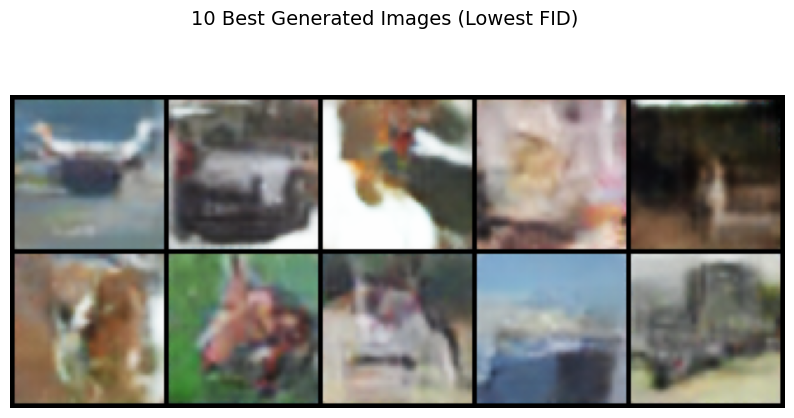

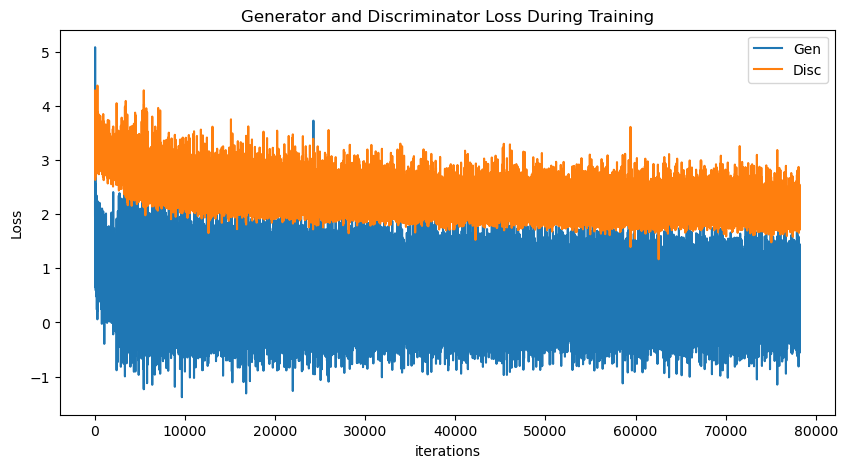

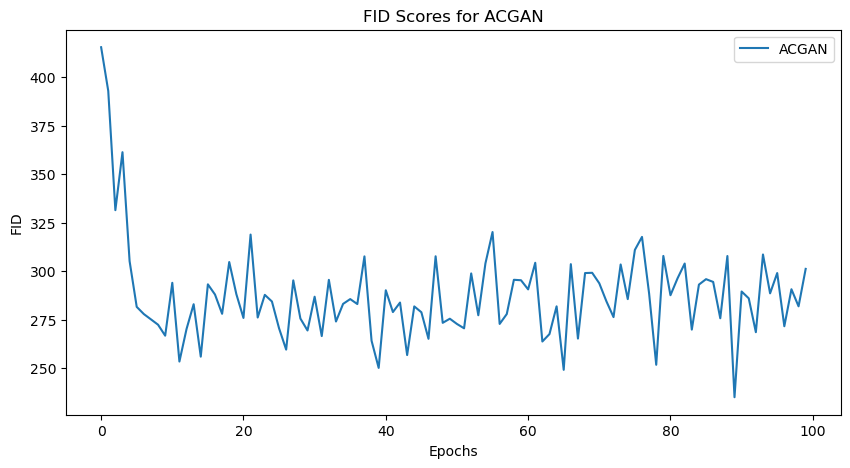

In [ ]:
# Cell 1: Imports (mostly the same, added nn.utils.spectral_norm)
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
import pandas as pd
from ipynb.fs.full.FID import calculate_fretchet
from torch.nn.utils import spectral_norm # <-- Import Spectral Norm


# Cell 2: Hyperparameters and DataLoader (unchanged)
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 2e-4
BATCH_SIZE = 64
image_size = 64
channels_img = 3  
noise_dim = 100
max_epochs = 100
disc_features = 64 
gen_features = 64 
num_classes = 10
embed_size = 100
# criticItr = 5 (No longer needed for this loss structure)


dataset = datasets.CIFAR10(root="./dataset/CIFAR10", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5 for _ in range(channels_img)], [0.5 for _ in range(channels_img)]),
                           ]))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


# Cell 3: UPDATED Generator (Uses BatchNorm)
class Generator(nn.Module):
    def __init__(self, num_classes, img_size, embed_size, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.net = nn.Sequential(
            # Input: noise_dim + embed_size
            nn.ConvTranspose2d(channels_noise + embed_size, features_g * 8, 4, 1, 0, bias=False), # 4x4
            self.block(features_g * 8, features_g * 4, 4, 2, 1),  # 8x8
            self.block(features_g * 4, features_g * 2, 4, 2, 1),  # 16x16
            self.block(features_g * 2, features_g, 4, 2, 1),      # 32x32
            nn.ConvTranspose2d(features_g, channels_img, 4, 2, 1, bias=False), # 64x64
            nn.Tanh(),
        )
        self.embed = nn.Embedding(num_classes, embed_size)

    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels, momentum=0.8), # Using 0.8 momentum
            nn.ReLU(),
        )

    def forward(self, x, labels):
        # x shape: (N, channels_noise, 1, 1)
        # labels shape: (N)
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3) # (N, embed_size, 1, 1)
        x = torch.cat([x, embedding], dim=1) # (N, channels_noise + embed_size, 1, 1)
        return self.net(x)

# Cell 4: UPDATED Discriminator (Uses Spectral Norm)
class Discriminator(nn.Module):
    def __init__(self, num_classes, img_size, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # Input: 3 x 64 x 64
            spectral_norm(nn.Conv2d(channels_img, features_d, 4, 2, 1, bias=False)), # 32x32
            nn.LeakyReLU(0.2),
            self.block(features_d, features_d * 2, 4, 2, 1),      # 16x16
            self.block(features_d * 2, features_d * 4, 4, 2, 1),  # 8x8
            self.block(features_d * 4, features_d * 8, 4, 2, 1),  # 4x4
        )
        
        # Head 1: Real or Fake (Adversarial) - No sigmoid for Hinge Loss
        self.adv_layer = nn.Sequential(
            spectral_norm(nn.Conv2d(features_d * 8, 1, 4, 1, 0, bias=False)),
        )
        
        # Head 2: Class prediction (Auxiliary) - No softmax for CrossEntropyLoss
        self.aux_layer = nn.Sequential(
            spectral_norm(nn.Conv2d(features_d * 8, num_classes, 4, 1, 0, bias=False)),
        )

    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        # No BatchNorm when using Spectral Norm
        return nn.Sequential(
            spectral_norm(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
            ),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        x = self.disc(x)
        # Flatten the output for the two heads
        source_output = self.adv_layer(x).view(x.size(0), -1)
        class_output = self.aux_layer(x).view(x.size(0), -1)
        
        return source_output, class_output
    

# Cell 5: Weight Init (unchanged)
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
            
            
# Cell 6: Initialization (Updated)
gen = Generator(num_classes, image_size, embed_size, noise_dim, channels_img, gen_features).to(device)
disc = Discriminator(num_classes, image_size, channels_img, disc_features).to(device)
initialize_weights(gen)
initialize_weights(disc)

fixed_noise = torch.randn(32, noise_dim, 1, 1).to(device)
# Generate 3-4 samples for each of the 10 classes
fixed_labels = torch.arange(0, num_classes).repeat(4)[:32].to(device)
step = 0

disOptim = optim.Adam(disc.parameters(), learning_rate, betas=(0.0, 0.999))
genOptim = optim.Adam(gen.parameters(), learning_rate, betas=(0.0, 0.999))

#  only need the auxiliary (classification) loss now
auxiliary_loss = nn.CrossEntropyLoss()

GenLoss = []
DiscLoss = []
img_list = []
iters = 0
FID_list = []
best_fid = float('inf')


# Cell 7: UPDATED Training Loop (with Hinge Loss)
gen.train() 
disc.train()

print("Starting Training Loop...")
for epoch in range(max_epochs):
    epoch = epoch + 1
    for batch_idx, (realImg, labels) in enumerate(dataloader):
        real = realImg.to(device)
        real_labels = labels.to(device)
        miniBatch = real.shape[0]

        # ---------------------
        #  Train Discriminator
        # ---------------------
        disc.zero_grad()

        # --- Train with REAL images ---
        real_source_output, real_class_output = disc(real)
        
        # Hinge Loss for real images
        errD_real_adv = torch.mean(F.relu(1.0 - real_source_output))
        # Auxiliary (classification) loss for real images
        errD_real_aux = auxiliary_loss(real_class_output, real_labels)
        errD_real = errD_real_adv + errD_real_aux
        
        errD_real.backward()

        # --- Train with FAKE images ---
        noise = torch.randn(miniBatch, noise_dim, 1, 1).to(device)
        fake_labels = torch.randint(0, num_classes, (miniBatch,)).to(device)
        fake = gen(noise, fake_labels)

        fake_source_output, _ = disc(fake.detach()) # don't need class output for fake
        
        # Hinge Loss for fake images
        errD_fake_adv = torch.mean(F.relu(1.0 + fake_source_output))
        errD_fake_adv.backward()
        
        # Total D loss and optimizer step
        loss_disc = errD_real + errD_fake_adv
        disOptim.step()

        # -----------------
        #  Train Generator
        # -----------------
        gen.zero_grad()
        
        # Get D's output for fake images
        fake_source_output, fake_class_output = disc(fake)
        
        # Hinge Loss for generator (wants D to output positive)
        errG_adv = -torch.mean(fake_source_output)
        # Auxiliary loss for generator (wants D to classify correctly)
        errG_aux = auxiliary_loss(fake_class_output, fake_labels)
        
        loss_gen = errG_adv + errG_aux
        
        loss_gen.backward()
        genOptim.step()

        # --- Logging and FID ---
        GenLoss.append(loss_gen.detach().cpu())
        DiscLoss.append(loss_disc.detach().cpu())
        
        if (iters % 500 == 0) or ((epoch == max_epochs) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake_grid = gen(fixed_noise, fixed_labels).detach().cpu()
            img_list.append(utils.make_grid(fake_grid, padding=2, normalize=True))
            
        iters += 1
    
    # --- End of Epoch ---
    # Calculate FID (using last batches for a rough epoch-end score)
    fretchet_dist = calculate_fretchet(real, fake.detach()) 
    FID_list.append(fretchet_dist)
    
    if fretchet_dist < best_fid:
        best_fid = fretchet_dist
        best_fake = gen(fixed_noise, fixed_labels).detach().cpu()
    
    if epoch % 5 == 0:
        print(f"Epoch [{epoch}/{max_epochs}] Batch {batch_idx+1}/{len(dataloader)} \
              Loss D: {loss_disc:.3f}, Loss G: {loss_gen:.3f}, FID Score: {fretchet_dist:.3f}")


print("Training finished. Plotting results...")

# Display the 10 best generated images in a grid
plt.figure(figsize=(10, 5))
plt.suptitle("10 Best Generated Images (Lowest FID)", fontsize=14)
grid = utils.make_grid(best_fake[:10], nrow=5, normalize=True)
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis("off")
plt.show()       

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(GenLoss,label="Gen")
plt.plot(DiscLoss,label="Disc")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('ACGAN_SNGAN_LOSS.pdf', format='pdf', dpi=100, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,5))
plt.title("FID Scores for ACGAN")
plt.plot(FID_list,label="ACGAN")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()
plt.savefig('ACGAN_SNGAN_FID.pdf', format='pdf', bbox_inches='tight')
plt.show()

np.save('ACGAN_SNGAN_FID', FID_list)